# Tarea Semana 8: Generative Learning

Equipo: Alan De Loa, Leonardo Lopez, Isaac Zaragoza, Luis Diaz, Luis Guzman  
Fecha: 18-11-2025

**Objetivo:** El objetivo principal es entrenar un modelo capaz de codificar las imágenes en un espacio latente de baja dimensión y posteriormente reconstruirlas, preservando la forma y estructura del dígito original. A través de este enfoque se busca comprender cómo los autoencoders aprenden representaciones compactas de los datos y evaluar su capacidad para generar reconstrucciones coherentes.


# 1 Introducción

El aprendizaje generativo constituye una de las áreas más relevantes dentro del Deep Learning, ya que permite a los modelos aprender la estructura interna de un conjunto de datos y generar nuevas muestras que conservan sus características esenciales. En este proyecto se implementa un Autoencoder Convolucional utilizando el dataset MNIST, el cual contiene imágenes en escala de grises de dígitos manuscritos.  

# 2 Exploración, explicación y limpieza de datos


El dataset MNIST está compuesto por 70,000 imágenes de dígitos escritos a mano, cada una con resolución 28×28 píxeles y en escala de grises.      

- Normalización: Los valores de los píxeles (0–255) se escalan al rango 0–1 para mejorar la estabilidad numérica durante el entrenamiento.  
- Estructura :   El conjunto se divide en 60,000 imágenes para entrenamiento y 10,000 para prueba.  
- Reformateo de dimensiones: Se agrega una dimensión de canal para adaptar los datos a las capas convolucionales, transformando cada imagen de (28, 28) a (28, 28, 1).
- Visualización:  Se visualizan algunas de las imágenes para confirmar que los datos se cargaron correctamente y que la limpieza es adecuada.


Shape del dataset: (60000, 28, 28)
Número de instancias: 60000
Dimensiones de cada imagen: (28, 28)


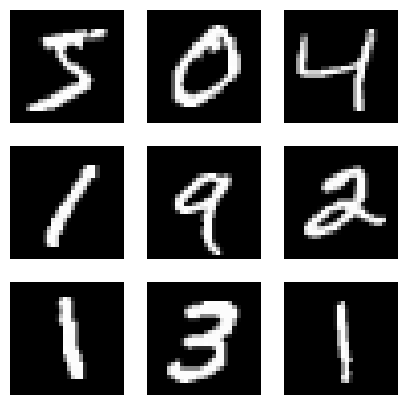

In [ ]:
import tensorflow as tf ## cargar tensorflow
import matplotlib.pyplot as plt # cargar matplotlib para visualización

# Cargamos el dataset MNIST desde Keras.
# Este dataset contiene imágenes de dígitos escritos a mano (0–9),
# cada una con tamaño 28x28 pixeles en escala de grises.
# Solo nos interesan las imágenes, no las etiquetas, por eso se ignoran con "_".
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

# Mostramos información básica del dataset cargado
print("Shape del dataset:", x_train.shape)
print("Número de instancias:", x_train.shape[0])
print("Dimensiones de cada imagen:", x_train.shape[1:])



# Normalización de los datos.
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Añadimos dimensión de canal (necesaria para redes convolucionales)
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

# Visualizamos algunas imágenes
plt.figure(figsize=(5,5))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_train[i].squeeze(), cmap="gray")
    plt.axis("off")
plt.show()

# 3) Desarrollo del Modelo de Deep Learning (25%)


Para este proyecto se construyó un Autoencoder Convolucional, el cual consta de dos componentes principales: encoder y decoder.    

## Encoder (codificador)  

Su función es transformar la imagen de entrada en un vector compacto del espacio latente.
Incluye:  

-Capas convolucionales con activación ReLU  
-Reducción progresiva de la resolución mediante strides  
-Aplanamiento de los mapas de características  
-Capa densa que genera un vector latente de 64 dimensiones  

El encoder aprende a capturar patrones relevantes como contornos, formas y trazos característicos de los dígitos.  

## Decoder (decodificador)  

Toma el vector latente y reconstruye la imagen original mediante:

-Capa densa inicial seguida de reestructuración a un volumen tridimensional  
-Capas de Conv2DTranspose para recuperar la resolución original  
-Activación sigmoid en la última capa para producir un mapa de píxeles entre 0 y 1  

## Autoencoder

El modelo se entrena comparando la imagen reconstruida con la imagen original:  

-Entrada: x_train  
-Salida objetivo: también x_train (porque reconstruye la misma imagen)  
-Pérdida: binary crossentropy  
-Optimizador: Adam   
--Entrenamiento: 10 épocas con batch de 128  

Este enfoque permite que el modelo aprenda representaciones latentes compactas y que, a su vez, pueda generar imágenes que preserven la estructura del dígito original.  






In [4]:
from tensorflow.keras import layers, models

# Definimos la dimensión del espacio latente.
latent_dim = 64

# Encoder
encoder = models.Sequential([
    layers.Input(shape=(28,28,1)),
    layers.Conv2D(32, 3, activation="relu", strides=2, padding="same"), # Primera capa convolucional
    layers.Conv2D(64, 3, activation="relu", strides=2, padding="same"), # Segunda capa convolucional
    layers.Flatten(), # Aplanamiento
    layers.Dense(latent_dim)
])

# Decoder
# El decoder toma el vector latente y reconstruye una imagen de 28x28x1.
decoder = models.Sequential([
    layers.Input(shape=(latent_dim,)),
    layers.Dense(7*7*64, activation="relu"),
    layers.Reshape((7,7,64)),
    layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu"),
    layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu"),
    layers.Conv2DTranspose(1, 3, padding="same", activation="sigmoid")
])

# Definimos las entradas del modelo
inputs = layers.Input(shape=(28,28,1))
encoded = encoder(inputs)
decoded = decoder(encoded)

# Autoencoder
autoencoder = models.Model(inputs, decoded)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

autoencoder.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 64)             │       219,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 28, 28, 1)      │       259,521 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 479,105 (1.83 MB)

 Trainable params: 479,105 (1.83 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.1566 - val_loss: 0.0804
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.0763 - val_loss: 0.0722
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - loss: 0.0713 - val_loss: 0.0696
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - loss: 0.0692 - val_loss: 0.0680
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - loss: 0.0680 - val_loss: 0.0672
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - loss: 0.0672 - val_loss: 0.0665
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.0665 - val_loss: 0.0661
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - loss: 0.0661 - val_loss: 0.0658
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - loss: 0.0657 - val_loss: 0.0655
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.0654 - val_loss: 0.0653


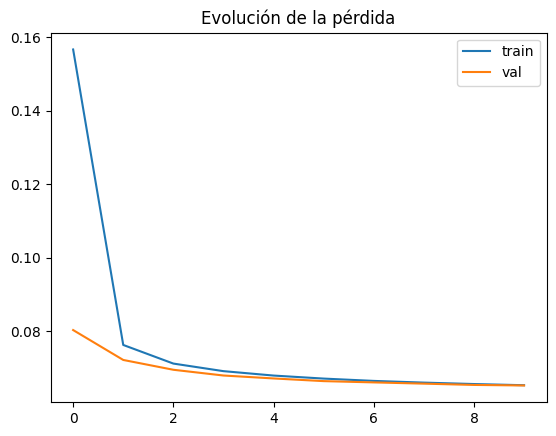

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


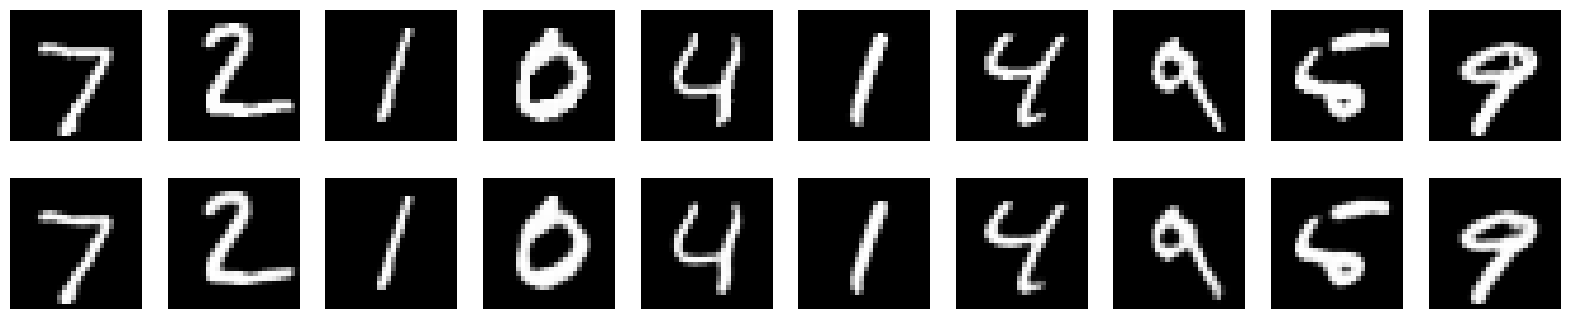

In [3]:
# Entrenamos el modelo
history = autoencoder.fit(
    x_train, x_train,
    epochs=10,
    batch_size=128,
    validation_data=(x_test, x_test)
)

# Graficamos la pérdida
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.legend()
plt.title("Evolución de la pérdida")
plt.show()

# Reconstrucción de imágenes
decoded_imgs = autoencoder.predict(x_test[:10])

plt.figure(figsize=(20,4))
for i in range(10):
    # Original
    plt.subplot(2,10,i+1)
    plt.imshow(x_test[i].squeeze(), cmap="gray")
    plt.axis("off")
    # Reconstruida
    plt.subplot(2,10,i+11)
    plt.imshow(decoded_imgs[i].squeeze(), cmap="gray")
    plt.axis("off")
plt.show()

# 4 Resultados e Interpretación

Durante el entrenamiento se observa la evolución de la pérdida tanto en el conjunto de entrenamiento como en el de validación. La disminución progresiva de la pérdida indica que el modelo está aprendiendo a reconstruir las imágenes de manera más precisa.

Se comparan imágenes originales con sus reconstrucciones:
- Las reconstrucciones muestran que el modelo logra capturar la estructura básica de los dígitos.
- Aunque no son idénticas a las originales, reflejan la capacidad del autoencoder para aprender patrones y generar imágenes similares.
Se destaca que se podrían probar diferentes hiperparámetros (dimensión latente, número de capas, funciones de activación) o incluso otras funciones de pérdida (MAE, MSE) para evaluar cómo cambia la calidad de las reconstrucciones.


# 5 Justificación del diseño  

Se eligió esta arquitectura porque:  

-Las convoluciones capturan patrones visuales locales esenciales en los dígitos.  
-El espacio latente de 64 dimensiones permite una compresión útil sin pérdida significativa de calidad.  
-Las convoluciones transpuestas facilitan la reconstrucción gradual de la imagen.  
-La pérdida binaria y la normalización en [0,1] optimizan la nitidez de las reconstrucciones.  
-La arquitectura completa es eficiente, estable y adecuada para introducir conceptos de aprendizaje generativo.  

# 5 Conclusiones

El notebook demuestra cómo un Autoencoder convolucional puede aprender representaciones latentes de un dataset de imágenes y generar reconstrucciones similares a las originales. Este enfoque es una introducción práctica al aprendizaje generativo y sienta las bases para explorar modelos más avanzados como Variational Autoencoders (VAE) o Generative Adversarial Networks (GANs).

En conclusión, el modelo cumple con el objetivo de mostrar cómo las redes neuronales pueden capturar patrones en datos visuales y utilizarlos para generar nuevas instancias, abriendo la puerta a aplicaciones más complejas en visión por computadora y generación de contenido.
